# Predicting movie genre from a synopsis

This is an interesting problem in machine learning combining **text analysis** and **multilabel prediction**.

The result is a model with an excellent **average f1$_{micro}$ test score of 0.57**. The model is an ensemble of naive bayes, support vector machines, random forest and stochastic gradient descent reached after reached after wrangling the data and cross validating each approach seperately.

Wrangling text data presents an interesting problem since you can't make a plot in 10000 dimensions. However by using mutual information functions to identify features that were overfitted (for example names and numbers) I improved the generalization of the fit.

Multilabel classification is also a rich area of research. While some models can natively handle multiple labels (like random forests) most need adaptation. And to improve the f1 score I found that a thresholding function was needed which both varied the cutoff score required to predict a label and mandated a minimum number of predicted labels per movie.

Brevity demands that I not show all of the dead ends that I pursued in this project. Where a decision appears precient I have attempted justify the choice in the surrounding text.

The outline is as follows:

1. The data is imported and prepped for analysis.
2. The features are analysed and appropriate choices made to improve the fit.
3. A dummy model is defined to create a reasonable benchmark
4. Multilabel classification classes are defined to generalise single label models and provide adjustable cutoffs.
5. A number of models are tested, with parameters found through cross validation.
6. Test set result of final model
7. A short discussion on future work

In [23]:
import pandas as pd
import chardet
import re as re
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

#some useful distributions
from scipy.stats import expon as sp_expon
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#sklearn utilities
from sklearn.base import MetaEstimatorMixin,BaseEstimator, TransformerMixin,ClassifierMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer


#Models  
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC

## 1. Import movie data and prepare it for analysis

There are two data files. One containing the basic information about the movie (name, country, genre etc) and another file containing the synopses. Let's import the first file.

In [2]:
movieData = pd.read_csv('movie.metadata.tsv', sep='\t', header=0, encoding='utf-8',
                        names=["WikipediaID", "FreebaseID", "name", "date", "boxOffice", "runtime",
                               "languages", "countries", "genres"],
                        usecols=["WikipediaID", "name", "date", "languages", "countries", "genres"],
                        index_col=0)
movieData.dropna(subset=['genres'], inplace=True)#this was found to improve the quality of the fit

Let's look at what a sample of this data lookes like

In [3]:
movieData.ix[31186339]

/u/saneem/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


name                                          The Hunger Games
date                                                2012-03-12
languages                   {"/m/02h40lc": "English Language"}
countries            {"/m/09c7w0": "United States of America"}
genres       {"/m/03btsm8": "Action/Adventure", "/m/06n90":...
Name: 31186339, dtype: object

Since we are interested specifically in predicting the genre of the movie, let's looks at that closer. The genre information is presented with some tagging information that we don't need, for example

In [4]:
movieData["genres"].ix[31186339]

/Users/saneem/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


u'{"/m/03btsm8": "Action/Adventure", "/m/06n90": "Science Fiction", "/m/02kdv5l": "Action", "/m/07s9rl0": "Drama"}'

So let's just extract the genre information we want

In [4]:
def extractTags(string):
    return re.findall('"([\w\s]+)"', string)

movieData["genres"] = movieData["genres"].apply(extractTags)
movieData["genres"].ix[3196793]

/u/saneem/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


[u'Mystery', u'Biographical film', u'Drama', u'Crime Drama']

We can use the same extractor to get the language and country tags, although neither the countries nor the languages will be used in the current analysis. In fact we are going to focus on predicting the genre for english language movies only, at least for the time being.

In [5]:
movieData["languages"] = movieData["languages"].apply(extractTags)
movieData["countries"] = movieData["countries"].apply(extractTags)

isInEnglish = lambda langauges : u'English Language' in langauges
movieData = movieData[movieData.languages.apply(isInEnglish)]

Now we will import the synopsis data that we will use to predict the genres. First let's check the encoding

In [7]:
file_object  = open('plot_summaries.txt', 'r')
print file_object.read(500) 
rawdata = file_object.read()
# chardet.detect(rawdata)

23890098	Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
31186339	The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole surviv


Confident that the data is in the standard utf-8 format, let's import the data

In [8]:
plot = pd.read_csv("plot_summaries.txt", sep='\t', encoding='utf-8', 
                   names=["ident", "synopsis"], index_col=0)

The summary data simply contains the ID number and the synopsis, e.g.

In [9]:
plot.ix[31186339]

/u/saneem/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


synopsis    The nation of Panem consists of a wealthy Capi...
Name: 31186339, dtype: object

Now let's combine the two files, pairing each movie with its synopsis

In [10]:
result = pd.merge(movieData, plot, left_index=True, right_index=True, how='inner')
result.head()

,name,date,languages,countries,genres,synopsis
9363483,White Of The Eye,1987,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
18998739,The Sorcerer's Apprentice,2002,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
6631279,Little city,1997-04-04,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Drama, Comedy...","Adam, a San Francisco-based artist who works a..."
171005,Henry V,1989-11-08,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
11250635,The Mechanical Monsters,NaN,[English Language],[United States of America],"[Science Fiction, Adventure, Animation, Short ...",The story starts as one of the robots flies i...


### Prepare the training labels

We first need to transform the training labels. At the moment they look like this

In [11]:
result.genres[:1]

9363483    [Thriller, Erotic thriller, Psychological thri...
Name: genres, dtype: object

These labels need to be binarized so that each genre is represented by a column and a film with a given genre is represented by a 1 in the approriate column. However there are over 300 genres listed in the wikipedia data and not all of them are what we might typically think of as a genre. They can be a detail of the movie content such as 'Airplanes and airports', tell you the place or language of the movie, like 'Bengali Cinema', or even the ditribution, e.g. u'Roadshow theatrical release'. Such descriptions are not really genres and so should be removed.

In [12]:
toDelete = [u'Absurdism', u'Airplanes and airports', u'Albino bias',u'Americana',u'Animal Picture',u'Animals',u'Anthology', u'Anthropology', u'Archaeology',u'Archives and records',u'Art film', u'Beach Film',u'Beach Party film', u'Bengali Cinema',u'Blaxploitation', u'Bollywood',u'British Empire Film', u'British New Wave',u'Buddy film',u'Business', u'Camp',u'Cavalry Film', u'Chase Movie', u'Chinese Movies',u'Christmas movie',u'Cold War',u'Coming of age', u'Computers',u'Cult',u'Cyberpunk', u'Dogme 95', u'Doomsday film',u'Early Black Cinema',u'Education', u'Educational', u'Environmental Science',u'Ensemble Film', u'Escape Film', u'Essay Film', u'Existentialism',u'Experimental film', u'Exploitation', u'Expressionism', u'Fan film', u'Feature film', u'Female buddy film', u'Feminist Film', u'Fictional film', u'Filipino', u'Filipino Movies', u'Film', u'Film adaptation',u'Filmed Play', u'Foreign legion',u'Giallo',u'Goat gland', u'Gothic Film',u'Gross out',u'Hagiography', u'Holiday Film', u'Indie', u'Japanese Movies', u'Journalism',u'Jungle Film', u'Juvenile Delinquency Film',
            u'Kafkaesque', u'Kitchen sink realism', u'Latino', u'Libraries and librarians', u'Linguistics',u'Live action',u'Media Studies',u'Medical fiction',u'Mondo film',u'Movie serial',u'Mumblecore',u'Nature',u'New Hollywood', u'News',u'Northern', u'Nuclear warfare', u'Parkour in popular culture',u'Patriotic film', 
            u'Pinku eiga', u'Plague', u'Point of view shot',u'Prison',u'Private military company',u'Propaganda film',u'Reboot', u'Remake', u'Religious Film',u'Roadshow theatrical release',
            u'School story', u'Sexploitation', u'Sponsored film', u'Short Film',u'Singing cowboy', u'Slice of life story',u'Social issues', u'Social problem film', u'Sponsored film', u'Star vehicle',u'Statutory rape', u'Steampunk', u'Stoner film',u'Superhero', u'Superhero movie', u'Surrealism',u'Sword and Sandal', u'Sword and sorcery', u'Sword and sorcery films',  u'Television movie', u'The Netherlands in World War II',u'Tragedy', u'Travel', u'World cinema', u'Wuxia',u'Z movie'] 

Other times the genre listed can be a combinatation of several genres and so should be categorised as both seperately. This means replacing 'Action Comedy' with 'Action' and 'Comedy', and 'Alien Film' with 'Creature Film' and'Science Fiction'. Furthermore we can identify subgenres and categorise by the parent genre, for example by replacing 'Parody' with 'Comedy'. And finally we can idnetify missspellings and plurals (replacing 'Sport' with 'Sports' and 'Comdedy' with 'Comedy').

In [13]:
toReplace = [(u'Acid western', [u'Western']),(u'Action Comedy', [u'Action', u'Comedy']),(u'Action Thrillers', [u'Action', u'Thriller']),(u'Addiction Drama', [u'Drama']),(u'Adventure Comedy',[u'Adventure', u'Comedy']),(u'Alien Film', [u'Creature Film', u'Science Fiction']),(u'Alien invasion', [u'Creature Film', u'Science Fiction']),(u'Animated Musical', [u'Animation']),(u'Animated cartoon', [u'Animation']),(u'Anime', [u'Animation']),(u'Auto racing', [u'Sports']),(u'Backstage Musical', [u'Musical']),(u'Baseball', [u'Sports']),(u'Biker Film', [u'Road movie']),(u'Biographical film', [u'Biography']),(u'Black comedy', [u'Comedy']),(u'Boxing', [u'Sports']),(u'Breakdance', [u'Dance']),(u'Buddy cop', [u'Crime']),(u'Caper story', [u'Crime', u'Comedy']),(u'Chick flick', [u'Romance']),(u'Childhood Drama',[u'Drama']),(u'Christian film', [u'Religious Film']),(u'Clay animation', [u'Animation']),
             (u'Combat Films', [u'Action']),(u'Comdedy',[u'Comedy']),(u'Comedy Thriller', [u'Comedy', u'Thriller']),(u'Comedy Western', [u'Comedy', u'Western']),(u'Comedy film', [u'Comedy']),(u'Comedy horror', [u'Comedy', u'Horror']),(u'Comedy of Errors', [u'Comedy']),(u'Comedy of manners', [u'Comedy']),(u'Computer Animation', [u'Animation']),(u'Concert film', [u'Music']),(u'Conspiracy fiction', [u'Thriller']),(u'Costume Adventure', [u'Adventure']),(u'Costume Horror', [u'Horror']),(u'Costume drama', [u'Drama']),(u'Courtroom Comedy',[u'Courtroom', u'Comedy']),(u'Courtroom Drama',[u'Courtroom', u'Drama']),(u'Creature Film', [u'Monster']), (u'Crime Comedy', [u'Crime', u'Comedy']),(u'Crime Drama', [u'Crime', u'Drama']),(u'Crime Fiction', [u'Crime']),(u'Crime Thriller', [u'Crime', u'Thriller']),(u'Demonic child', [u'Horror']),(u'Detective fiction', [u'Detective']),(u'Docudrama', [u'Drama']),(u'Domestic Comedy', [u'Comedy']),(u'Ealing Comedies', [u'Comedy']),(u'Epic Western', [u'Epic', u'Western']),(u'Erotic Drama', [u'Adult', u'Drama']),(u'Erotic thriller', [u'Adult', u'Thriller']),(u'Erotica', [u'Adult']),(u'Extreme Sports', [u'Sports']),(u'Family Drama', [u'Family Film', u'Drama']),
             (u'Fairy Tale', [u'Fantasy']),(u'Fairy tale', [u'Fantasy']),(u'Fantasy Adventure', [u'Fantasy', u'Adventure']),(u'Fantasy Comedy', [u'Fantasy', u'Comedy']),(u'Fantasy Drama', [u'Fantasy', u'Drama']),(u'Future noir', [u'Film noir']),(u'Gangster Film', [u'Crime']),(u'Gay', [u'LGBT']),(u'Gay Interest', [ u'LGBT']),(u'Gay Themed', [ u'LGBT']), (u'Gay pornography', [ u'LGBT', u'Adult']),(u'Gender Issues', [u'LGBT']),(u'Glamorized Spy Film', [u'Spy']),
             (u'Gulf War', [u'War film']),(u'Haunted House Film', [u'Horror']),(u'Hardcore pornography', [u'Adult']),(u'Heavenly Comedy', [u'Comedy']),(u'Heist', [u'Crime']),(u'Hip hop movies', [u'Music']),(u'Historical Documentaries', [u'History', u'Documentary']),(u'Historical Epic', [u'History']),(u'Historical drama', [u'History']),(u'Historical Drama', [u'History', u'Drama']),(u'Historical fiction', [u'History']),(u'Homoeroticism', [u'Adult', u'LGBT']),(u'Horror Comedy', [u'Horror', u'Comedy']),(u'Horse racing', [u'Sport']),(u'Humour', [u'Comedy']),(u'Hybrid Western', [u'Western']),(u'Indian Western', [u'Western']),(u'Inspirational Drama', [u'Drama']),(u'Instrumental Music', [u'Music']),(u'Interpersonal Relationships', [u'Drama']),(u'Jukebox musical', [u'Musical']),(u'Legal drama', [u'Courtroom']),(u'Marriage Drama', [u'Drama']),(u'Master Criminal Films', [u'Crime']),(u'Media Satire', [u'Comedy']),
             (u'Melodrama', [u'Drama']),(u'Mockumentary', [u'Comedy']),(u'Monster movie', [u'Monster']),(u'Movies About Gladiators', [u'History', u'Action']),(u'Musical Drama', [u'Musical', u'Drama']),(u'Musical comedy', [u'Musical', u'Comedy']), (u'Mythological Fantasy',[u'Fantasy']),(u'Natural disaster', [u'Disaster']), (u'Natural horror films', [u'Horror']),(u'Ninja movie', [u'Martial Arts Film']),(u'Operetta', [u'Musical']),(u'Outlaw', [u'Crime']),(u'Outlaw biker film', [u'Crime', u'Road movie']),(u'Parody', [u'Comedy']),(u'Period Horror', [u'Period', u'Horror']),(u'Period piece', [u'Period']),(u'Political cinema', [u'Politics']),(u'Political drama', [u'Politics', u'Drama']),(u'Political satire', [u'Politics', u'Comedy']),(u'Political thriller', [u'Politics', u'Thriller']),(u'Pornographic movie', [u'Adult']),(u'Pornography', [u'Adult']),(u'Prison', [u'Crime']),(u'Prison escape', [u'Crime']),(u'Prison film', [u'Crime']),(u'Psychological horror', [u'Horror']),(u'Psychological thriller', [u'Thriller']),
             (u'Punk rock', [u'Music']),(u'Race movie', ['Sports']),(u'Revisionist Fairy Tale', [u'Fantasy']),(u'Revisionist Western', [u'Western']),(u'Rockumentary', [u'Documentary', u'Music']),(u'Romance Film', [u'Romance']),(u'Romantic Film', [u'Romance']),(u'Romantic comedy', [u'Romance', u'Comedy']),(u'Romantic drama', [u'Romance', u'Drama']),(u'Romantic fantasy', [u'Romance', u'Fantasy']),(u'Samurai cinema', [u'Martial Arts Film']),(u'Satire', [u'Comedy']),(u'Sci Fi Pictures original films', [u'Science Fiction']),(u'Science fiction Western', [u'Science Fiction', u'Western']),(u'Screwball comedy', [u'Comedy']),(u'Sex comedy', [u'Comedy']),(u'Slapstick', [u'Comedy']),(u'Slasher', [u'Horror']),(u'Softcore Porn', [u'Adult']),(u'Space opera', [u'Science Fiction', u'Musical']),(u'Space western', [u'Science Fiction', u'Western']),(u'Spaghetti Western', [u'Western']),(u'Spaghetti western', [u'Western']),(u'Splatter film', [u'Horror']),(u'Sport', [ u'Sports']),(u'Stop motion', [u'Animation']),(u'Supermarionation', [u'Animation']),(u'Swashbuckler films', [u'Adventure']),
             (u'Therimin music', [u'Music']), (u'Time travel', [u'Science Fiction']),(u'Tragicomedy', [u'Comedy', u'Tragedy']),(u'Vampire movies', [u'Horror']),(u'War effort', [u'War film']),(u'Werewolf fiction', [u'Monster']),(u'Whodunit', [u'Detective']),(u'Women in prison films', [u'Prison']),(u'World History', [u'History']),(u'Workplace Comedy', [u'Comedy']),(u'Zombie Film', [u'Monster'])]

The following two functions can remove and replace genres.

In [14]:
class wordRemover():
    def __init__(self, word):
        self.word = word
        
    def removeWord(self, listOfWords):
        if self.word in listOfWords:
            index = listOfWords.index(self.word)
            del listOfWords[index]
        return listOfWords

In [15]:
class wordReplacer():
    def __init__(self, word, replacements):
        self.word = word
        self.replacements = replacements
        
    def replaceWord(self, listOfWords):
        if self.word in listOfWords:
            index = listOfWords.index(self.word)
            del listOfWords[index]
            for replacement in self.replacements:
                if replacement not in listOfWords:
                    listOfWords.append(replacement)
        return listOfWords

In [16]:
for word in toDelete:
    result.genres = result.genres.apply(wordRemover(word).removeWord)

for word, replacements in toReplace:
    result.genres = result.genres.apply(wordReplacer(word, replacements).replaceWord)
 

We now binarize the data and find a total of 40 different genres.

In [17]:
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(result.genres)

In [18]:
binarizer.classes_

array([u'Action', u'Adult', u'Adventure', u'Animation', u'Biography',
       u'Comedy', u'Courtroom', u'Crime', u'Dance', u'Detective',
       u'Disaster', u'Documentary', u'Drama', u'Dystopia', u'Epic',
       u'Family Film', u'Fantasy', u'Film noir', u'History', u'Horror',
       u'LGBT', u'Martial Arts Film', u'Monster', u'Music', u'Musical',
       u'Mystery', u'Period', u'Politics', u'Prison', u'Religious Film',
       u'Road movie', u'Romance', u'Science Fiction', u'Silent film',
       u'Sports', u'Spy', u'Supernatural', u'Suspense', u'Teen',
       u'Thriller', u'Tragedy', u'War film', u'Western'], dtype=object)

The genre data is stored as ones and zeros e.g.

In [19]:
y[:1]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

But we can easily see what genres this vector corresponds to by doing an inverse transform

In [20]:
binarizer.inverse_transform(y[:1])

[(u'Adult', u'Thriller')]

Note that there is some leakage from the training set to the test set by binarizing the data before the test train split. In practice this has no affect since we canot fit genres which aren't in the training set and so we will just predict false on all such genres not present in the training set.

Let's split the data set into training and test sets. We won't look at the test set again till the very end.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(result.synopsis,y,
                                                    train_size=0.7, random_state = 9588)

/u/saneem/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


And now let's look at the distribution of genres.

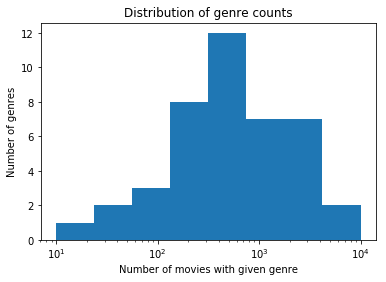

In [22]:
labelCounts = y_train.sum(axis=0)
n, bins, patches = plt.hist(labelCounts, bins=np.logspace(1, 4, 9))
plt.semilogx()
plt.title("Distribution of genre counts")
plt.xlabel("Number of movies with given genre")
plt.ylabel("Number of genres")

We see there are a handful of genres that appear in the training set less than a hundred times and some that appear many thousands of times with most appearing several hundred times.

## 2. Feature analysis and wrangling

Next I want to do some text wrangling as we prepare the synopsis for predictive analysis. It is helpful to do this in the context of just a single label. I will initially use Comedy as it describes a significant portion of the data

In [23]:
genreDF = pd.DataFrame(y_train, columns = binarizer.classes_)
genreDF.Comedy.sum()/genreDF.Comedy.count()

0.35782250158583706

So now let's wrangle the text. 

First, a review of the text shows that some of the data contains tags such as "{{plot}}"

In [24]:
X_train.ix[1952976][:24]

u'{{plot}} The film opens '

In fact these tags are contained in almost 5% of the training set. 

In [25]:
X_train.str.contains("{{\w*}}", case=False).mean()

0.045787440170693729

We don't just want to delete these tags once, we want easily manageable code to eventually create a data wrangling pripeline. So I'll create a transformer to delete these tags.

In [26]:
def deleteSynopsisTags(X):
    return X.str.replace("\s*{{\w*}}\s*", "", case=False)

deleteSynopsisTagsTransformer = FunctionTransformer(deleteSynopsisTags, validate=False)

X_wrangle_1 = deleteSynopsisTagsTransformer.fit_transform(X_train)

And we see that the tags have now gone.

In [27]:
X_wrangle_1.ix[1952976][:24]

u'The film opens in 1974, '

So now I want to start making fits to the Comedy genre data, identifying the most important features and so finding possible sources of error. 

First though I need to choose an appropraite score to measure the fit quality. I will choose the micro f1 score which balanaces precision (reducing false negatives) and accuracy (reducing false positives). The is implemented here for a single label (Later I will extend this to multilabel).

In [28]:
def customF1(hat, actual, **kwargs):
    accuracy = ((actual*hat).sum())/actual.sum()
    precision = ((actual*hat).sum())/hat.sum()
    if accuracy==0 or precision==0:
        f1= 0
    else:
        f1= 2.* pow(pow(accuracy, -1) + pow(precision, -1), -1)
    return f1
customF1Scorer = make_scorer(customF1, greater_is_better=True)

So let's identify the most important features and the quality of the fit. The folloiwng code vectorizes the synopsis, and prints out the 200 most important words for determing whether a movie is a comedy using a $\chi^2$ imformation metric. Next we perform a fit over the most important features and print the resulting cross validation score and training score. By printing both we will identify possible overfitting.

In [ ]:
def mostImportantFeatrures(X, y):
    count = CountVectorizer(lowercase=False, strip_accents='unicode', min_df = 3, stop_words='english')
    #print the most important features
    selector = SelectKBest(chi2, 200)
    X_Vec = count.fit_transform(X, y)
    X_select = selector.fit_transform(X_Vec, y)
    print np.unique([name for name, val in zip(count.get_feature_names(), 
                                               selector.get_support()) 
                     if val==True])
    #get a fit score based on the most important featrures
    MultinomialPipe = Pipeline([
                                ("count", count),
                                ("selector", SelectPercentile(chi2)),
                                ("model", MultinomialNB(alpha = 1e-9, fit_prior=False))
                               ])
    rs = RandomizedSearchCV(MultinomialPipe, param_distributions={"selector__percentile":sp_randint(1, 50)}, 
                            n_iter=10,
                            scoring=customF1Scorer, verbose=0, 
                            refit=True, n_jobs=-1, 
                            cv=3
                           )
    rs.fit(X, y)
    print "grid search best score = ", rs.best_score_
    print "grid search best param = ", rs.best_params_ 
    hYat = rs.predict(X)
    print "score on training data = ", customF1(y, hYat)

In [ ]:
mostImportantFeatrures(X_wrangle_1, genreDF.Comedy)

[u'Adam' u'Alfalfa' u'Alfie' u'Ambrose' u'Andy' u'Augie' u'Babe'
 u'Beethoven' u'Beverly' u'Big' u'Bishop' u'Bob' u'Bond' u'Boris'
 u'British' u'Buddy' u'Bugs' u'Butch' u'Buzz' u'Calvin' u'Captain' u'Cash'
 u'Charlie' u'Cheech' u'Chester' u'Chip' u'Chuck' u'Chucky' u'Clouseau'
 u'Coyote' u'Curly' u'Cynthia' u'Daffy' u'Dave' u'Dewey' u'Dexter'
 u'Dickie' u'Dr' u'Dreyfus' u'Elliot' u'Elmer' u'Elwood' u'Ernest' u'Ernie'
 u'Evan' u'Evil' u'Fitz' u'Garfield' u'George' u'Georgia' u'German'
 u'Gidget' u'Gonzo' u'Harold' u'Herbie' u'Hollywood' u'Ira' u'Jackie'
 u'Jacob' u'Japanese' u'Jerry' u'John' u'Joseph' u'Josh' u'Junior' u'Ka'
 u'Kui' u'Larry' u'Loretta' u'Louie' u'Madea' u'Madonna' u'Mame' u'Martin'
 u'Massie' u'Miss' u'Moe' u'Monty' u'Mr' u'Murtaugh' u'Neha' u'Ollie'
 u'Oscar' u'Pink' u'Popeye' u'Porky' u'Ralph' u'Ramona' u'Riggs' u'Roger'
 u'Sach' u'Sam' u'Sharpay' u'Shemp' u'Shrek' u'Slip' u'Spanky' u'Speedy'
 u'Spike' u'Stan' u'Stooges' u'TV' u'Tarzan' u'Tom' u'Wally' u'War'
 u'Wilby

We see that many of the most important features are names. While we might imagine that a few names could hold some predictive power, the use of names seems likely to contribute to the overfitting we observe. Lets remove them.

In [ ]:
def noCaps(X):
    return X.str.replace(r'([A-Z])\w+', "", case=True)

noCapsTransform = FunctionTransformer(noCaps, validate=False)

X_wrangle_2 = noCapsTransform.fit_transform(X_wrangle_1)
mostImportantFeatrures(X_wrangle_2, genreDF.Comedy)

[u'accidentally' u'actor' u'actors' u'advertising' u'advice' u'aircraft'
 u'alive' u'antics' u'army' u'aspiring' u'attack' u'attacked' u'attacks'
 u'audience' u'awkward' u'bachelor' u'ball' u'band' u'battle' u'best'
 u'bet' u'big' u'bird' u'blood' u'body' u'bong' u'boyfriend' u'boys'
 u'bumbling' u'butler' u'canary' u'carrot' u'cartoon' u'cat' u'cave'
 u'ceremony' u'chase' u'chef' u'child' u'class' u'club' u'college'
 u'comedy' u'comic' u'command' u'commander' u'company' u'competition'
 u'contest' u'cow' u'creature' u'credits' u'crime' u'crooks' u'crush'
 u'dad' u'dance' u'date' u'dates' u'dating' u'daughter' u'dead' u'death'
 u'decide' u'decides' u'dentist' u'die' u'died' u'dies' u'dinner' u'doesn'
 u'dog' u'drug' u'duo' u'dying' u'eccentric' u'end' u'ends' u'escape'
 u'evidence' u'ex' u'executed' u'fatally' u'feelings' u'fired' u'forces'
 u'friends' u'fun' u'game' u'gets' u'getting' u'gig' u'girlfriend' u'girls'
 u'golf' u'gun' u'guys' u'happy' u'having' u'hockey' u'hospital' u'hotel

We have reduced overfitting by quite a bit, although it would have been better if this gain had come from increased predictive power rather than reducing the training score. 

Next, we see a number of very similar words appearing, perhaps suggesting that we should use stemming to improve the fit

In [ ]:
from nltk.stem.porter import *
from nltk import tokenize
stemmer = PorterStemmer()
tokenizer = tokenize.WordPunctTokenizer()
def stemCustom(X):
    splitStemJoin = lambda string: ' '.join([stemmer.stem(word) for word in tokenizer.tokenize(string)])
    return X.apply(splitStemJoin)

stemTransform = FunctionTransformer(stemCustom, validate=False)

X_wrangle_3 = stemTransform.fit_transform(X_wrangle_2)
mostImportantFeatrures(X_wrangle_3, genreDF.Comedy)

[u'accident' u'actor' u'advertis' u'advic' u'aircraft' u'aliv' u'ambush'
 u'antic' u'apolog' u'arm' u'armi' u'attack' u'audienc' u'awkward'
 u'bachelor' u'ball' u'band' u'battl' u'best' u'bet' u'big' u'black'
 u'blood' u'bodi' u'boyfriend' u'brutal' u'bumbl' u'burn' u'butler' u'buy'
 u'canari' u'carrot' u'cartoon' u'cat' u'cave' u'chase' u'cheerlead'
 u'chef' u'child' u'class' u'colleg' u'comedi' u'comic' u'command'
 u'compani' u'competit' u'contest' u'costum' u'creatur' u'credit' u'crime'
 u'dad' u'danc' u'dark' u'date' u'dead' u'death' u'decid' u'demon'
 u'dentist' u'desert' u'destroy' u'die' u'dinner' u'disguis' u'doesn'
 u'dog' u'dragon' u'dress' u'drug' u'eccentr' u'embarrass' u'end' u'enemi'
 u'escap' u'everyon' u'evid' u'ex' u'fatal' u'feel' u'fight' u'fighter'
 u'forc' u'friend' u'fun' u'girlfriend' u'golf' u'gun' u'guy' u'happi'
 u'helicopt' u'hockey' u'hospit' u'hotel' u'human' u'idea' u'impress'
 u'inadvert' u'inept' u'infect' u'investig' u'job' u'kid' u'kill' u'killer'
 u'k

Again we appear to have reduced overfitting but without improving the actual fit. Let's try looking at a different genre.

In [ ]:
mostImportantFeatrures(X_wrangle_3, genreDF.Documentary)

[u'02' u'09' u'1976' u'1980' u'1990' u'1995' u'1996' u'1999' u'2000'
 u'2001' u'2002' u'2003' u'2004' u'2006' u'2007' u'2008' u'2009' u'2010'
 u'2011' u'3D' u'41' u'accessd' u'activist' u'agre' u'al' u'album' u'alleg'
 u'archiv' u'arriv' u'art' u'ask' u'attack' u'attempt' u'away' u'bailout'
 u'becom' u'befor' u'began' u'billion' u'bodybuild' u'booksel' u'break'
 u'camera' u'car' u'censorship' u'chase' u'chronicl' u'cite' u'clip' u'com'
 u'come' u'commentari' u'contemporari' u'context' u'contribut'
 u'controversi' u'coral' u'cove' u'cub' u'cultur' u'daughter' u'dead'
 u'decad' u'decid' u'deficit' u'democraci' u'democrat' u'demonstr'
 u'deregul' u'describ' u'die' u'director' u'discov' u'discuss' u'document'
 u'documentari' u'doe' u'dolphin' u'econom' u'economist' u'ere' u'escap'
 u'eugen' u'evolut' u'examin' u'explor' u'fall' u'father' u'featur' u'film'
 u'filmmak' u'flamingo' u'focu' u'focus' u'footag' u'friend' u'genocid'
 u'genr' u'girl' u'global' u'goe' u'gun' u'ha' u'head' u'help' u

Here the fit is very much worse than for comedy. Also notice notice the presence of numbers which could be a source of error so let's try removing them.

In [ ]:
def noDigits(X):
    return X.str.replace(r'\d+\,?\.?\d?', "")

noDigitsTransform = FunctionTransformer(noDigits, validate=False)

X_wrangle_4 = noDigitsTransform.fit_transform(X_wrangle_3)

In [ ]:
mostImportantFeatrures(X_wrangle_4, genreDF.Documentary)

[u'accessd' u'activist' u'agre' u'al' u'album' u'alleg' u'anoth' u'anti'
 u'apart' u'archiv' u'arriv' u'art' u'ask' u'attack' u'attempt' u'away'
 u'bailout' u'becom' u'befor' u'began' u'billion' u'bodybuild' u'booksel'
 u'boy' u'break' u'calf' u'camera' u'car' u'caus' u'censorship' u'chase'
 u'chronicl' u'cite' u'clip' u'coalit' u'com' u'come' u'commentari'
 u'contemporari' u'context' u'contribut' u'controversi' u'coral' u'cove'
 u'cub' u'cultur' u'daughter' u'dead' u'decad' u'decid' u'deficit'
 u'democraci' u'democrat' u'demonstr' u'depict' u'deregul' u'describ'
 u'die' u'director' u'discov' u'discuss' u'document' u'documentari' u'doe'
 u'dolphin' u'econom' u'economist' u'ere' u'escap' u'eugen' u'evolut'
 u'examin' u'excerpt' u'explor' u'fall' u'father' u'featur' u'fight'
 u'film' u'filmmak' u'flamingo' u'focu' u'focus' u'footag' u'friend'
 u'genocid' u'genr' u'girl' u'global' u'goe' u'gun' u'ha' u'head' u'health'
 u'help' u'hi' u'hide' u'highlight' u'histor' u'histori' u'home' u'hous

The fit is the same and, although there is a slightly greater ammount of overfitting, it makes sense to remove digits from the data set. Finally we need to transofmr the vectorised synopsis data into an numpy array and then bring all the steps together into a preprocessing pipeline.

In [ ]:
def transformToNp(X):
    return X.as_matrix().flatten()

transformToNpTransform = FunctionTransformer(transformToNp, validate=False)

X_wrangled = transformToNpTransform.fit_transform(X_wrangle_4)

preprocessing = Pipeline([("deleteTags", deleteSynopsisTagsTransformer), 
                          ("deleteCapitalizedWords", noCapsTransform), 
                          ("porterStemmer", stemTransform),
                          ("deleteDigits", noDigitsTransform),
                          ("toNumpy", transformToNpTransform)])



## 3. Dummy model and a reasonable baseline.

Before writing the dummy model I said I would first generalize the f1 score for multilabel classification. We can calculate the f1 score for each movie by comparing the predicted and actual genres (and ignoring labels that are absent from both). I then average the score over all movies.

In [ ]:
def averageF1Micro(y, yPredicted, **kwargs):
    #if a row in y has no labels assume that its genres were not in the training set and give 0
    return np.mean([f1_score(sub_y, sub_ypredicted, labels=[1], average='micro') 
                    if sum(sub_ypredicted)!=0 else 0 
                    for sub_y, sub_ypredicted in zip(y,yPredicted) if sum(sub_y)!=0] )

averageF1MicroScorer = make_scorer(averageF1Micro, greater_is_better=True)

An appropriate dummy model for a multilabel classification might be to predict the most frequently occuring labels in the data. So let's find the most frequent

In [ ]:
def nMostFrequent(n):
    assert(n>0)
    frequencies=(genreDF.sum()/genreDF.count())
    nMostFrequent = (frequencies.sort_values()[-n:]).index.tolist()
    return nMostFrequent

The five most frequent labels are

In [ ]:
nMostFrequent(5)

[u'Crime', u'Romance', u'Thriller', u'Comedy', u'Drama']

While we can find the most frequent labels, it is not clear how many give the best fit. So our dummy model will predict the n most frquent labels for each movie and, using cross validation, we'll find the number that gives the best score.

In [ ]:
class nMostFrequentClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n=1):
        self.n = n

    def fit(self, X, y):
        self.occurences_ = np.sum(y, axis=0)
        return self

    def predict(self, X):
        cutOffVal = np.sort(self.occurences_, axis=0)[-self.n]
        if (self.occurences_==cutOffVal).sum()==1:
            self.nMostFrequent_ = self.occurences_>=cutOffVal
        else:
            additionalToSelect = self.n - (self.occurences_>cutOffVal).sum()
            indexesOfAdditionals = np.argwhere(np.array([0,1,1,1])==1)[:additionalToSelect]
            additionals = np.array([[1 if i in indexesOfAdditionals else 0 for i in range(len(self.occurences_))]])
            self.nMostFrequent_ = additionals + self.occurences_>cutOffVal
        numPredicted = len(X)
        return np.array([self.nMostFrequent_.tolist()]*numPredicted)

Let's try predicting up to the 10 most frequent labels and plotting the results:

In [ ]:
pipeDummy = Pipeline([("nMostFrequent", nMostFrequentClassifier())])

dummCV = GridSearchCV(pipeDummy, param_grid={"nMostFrequent__n":[1,2,3,4,5,6,7,8,9,10]}, 
                          scoring=averageF1MicroScorer, verbose=1, 
                          refit=False, n_jobs=-1, cv=3)
dummCV.fit(X_wrangled, y_train)
print "    best score", dummCV.best_score_
print "    best param", dummCV.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
    best score 0.359050338086
    best param {'nMostFrequent__n': 2}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


(0.24, 0.38)

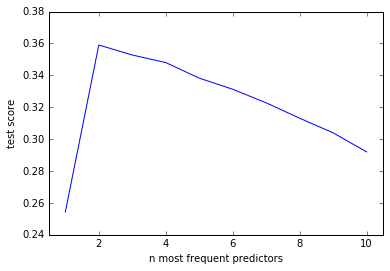

In [ ]:
plt.plot(range(1, 11), dummCV.cv_results_["mean_test_score"])
plt.ylabel("test score")
plt.xlabel("n most frequent predictors")
plt.xlim([0.5, 10.5])
plt.ylim([0.24, 0.38])

We see our dummy model has a best score of 0.35 which occurs when it predicts the 2 most frquent genres for every movie. Any other model has to beat this to be of value.

# 4. Multilabel classification classes 

Most machine learning algorithms do not natively support multiple labels. I need to write a number of classes that will help us adapt these standard algorithms for our purposes. 

Since I will be applying the machine learning algorithms to each label, some of which may appear only a small number of times in the data, I need a class that will not attempt to fit an impossibly small data set and instead will just return zero. This is the `MinSampleClassifier` and it takes an algorithm, a cutoff below which models will not be fitted and a description of wither the underlying algorithm has a decision function or a predict probability method. This last arguement will used later.

In [ ]:
class MinSampleClassifier(BaseEstimator, MetaEstimatorMixin):
    def __init__(self, clf=MultinomialNB(), limit=10, decisionFunction=False):
        self.clf = clf
        self.limit = limit
        self.decisionFunction = decisionFunction
        
    def fit(self, X, y):
        if sum(y)<self.limit:
            self.dataTooSmall_ = True
        else:
            self.dataTooSmall_ = False
            self.clf.fit(X,y)
        return self
    
    def predict(self, X):
        if self.dataTooSmall_:
            return np.array([np.array([0.])]*X.shape[0])
        else:
            return self.clf.predict(X)
        
    def decision_function(self, X):
        if self.dataTooSmall_:
            return np.array([np.array([0.])]*X.shape[0])
        elif self.decisionFunction:
            return self.clf.decision_function(X)
        else:
            return self.clf.predict_proba(X)[:,1]

Models fall in to two categories. Those, like naive bayes, which can predict the proability that a given data point has a specific label and those that use a decision function. In both cases there is a cutoff value below which a data point is deemed by the model not to have that label, for approaches that predict a probability that value is 0.5 and for models that have a decision function the value is 0 (which is the distance from some decision boundary). However thse values may not lead to the best f1 score and I would like to be able to tune the threshold to get the best fit. 

I will create a two step process. First I will take a machine learning algorithm and use it to transform the data into a measure of fit, either a probability or a decision function score.

In [ ]:
class PredictionTransformer(BaseEstimator, TransformerMixin, MetaEstimatorMixin):
    def __init__(self, clf=MultinomialNB(), decisionFunction=True):
        """Replaces all features with `clf.predict_proba(X)`"""
        self.clf = clf
        self.decisionFunction=decisionFunction
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        if self.decisionFunction:
            return self.clf.decision_function(X)
        else:
            X_array = np.asarray(X)
            probs = self.clf.predict_proba(X)
            return [val[:,1] if val.shape[1]==2 else [0]*val.shape[0] for val in probs ]

      

Next I will create a class that allows the value of the threshold to be raised or lowered. However this may lead to situations where no labels are predicted. In this case I want to predict the n labels with the highest scores or probabilities, even if those are quite low. An alternative method would be to predict the n most frequent labels if none have a sufficiently high probability. I found that this alternative lead to inferior results.

In [ ]:
def thresholdCalc(threshold, minCount, x):
        #predict values above a threshold or else the most confident minCount
    initialThreshold = x>=threshold
    if initialThreshold.sum() >=minCount:
        return initialThreshold
    else:
        indexes = np.argpartition(x, -minCount)[-minCount:]
        lowerThreshold = x[indexes].min()
        if lowerThreshold>0 and minCount<len(x):
            return x>=lowerThreshold
        else:
            return x>0
        
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, minCount = 2, transpose=True):
        """Classify samples based on whether they are above of below `threshold`"""
        self.threshold = threshold
        self.minCount = minCount
        self.transpose=transpose

    def fit(self, X, y):
        return self

    def predict(self, X):
        X_array = np.asarray(X)
        if self.transpose:
            returnVal = np.array([thresholdCalc(self.threshold, self.minCount, sub) for sub in X_array]).T
        else:
            returnVal = np.array([thresholdCalc(self.threshold, self.minCount, sub) for sub in X_array])
        return returnVal
    
    #This method is required by the OneVsRestClassifier 
    def predict_proba(self, X):
        return X

## 5. Defining and tuning models

All of the models we are going to try will have a number of parameters that must be tuned using cross validation. Rather than repeat this boiler plate code for each model I will create a simple function that searches the available parameter space for the best values printing out the best results. 

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def crossValidateRandom(X, Y, model, params=None, n_iter=100):
    rsCV = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter,
                            scoring=averageF1MicroScorer, verbose=1, 
                            refit=False, n_jobs=-1, 
                            cv=3
                           )
    fittedModel = rsCV.fit(X, Y)
    report(rsCV.cv_results_)
    return rsCV.best_params_

For each model I will use the same function to vectorize the text data, called CountVectorizer. Note that an alternative vectorizer exists, tfIdfVectorizer but with it I have found that the results are not as good.

In [ ]:
count = CountVectorizer(lowercase=False, strip_accents='unicode', stop_words='english')

# Naive Bayes

This model is a staple of any attempt at text analysis. For this model I will create a naive bayes model for each genre and then use the threshold predictor to find the most likely labels.

Some of the parameters I want to look at should be sampled uniformly, such as the threshold and the percentage of features needed to best predict each label. Other parameters need to be sampled unifromly in log space, such as $\alpha$ which smoothes the likelihood function of each feature. For this I create a quick custom distribution

In [ ]:
class logUniform():
    def __init__(self, low = -9, high = 0):
        self.rng = sp_uniform(low, high-low)#This distribution is constant between `loc` and ``loc + scale``.
        
    def rvs(self, **kwargs):
        return 10**(self.rng.rvs(**kwargs))

The model first vectorizes the data. Then for each label it selects the most important features and then applies Naive Bayes. Thresholding is then used to predict the best labels.

In [ ]:
selectThenNBPipe = Pipeline([("selector", SelectPercentile(chi2)),
                             ("prediction",MultinomialNB())])

multipleNB = OneVsRestClassifier(MinSampleClassifier(selectThenNBPipe, decisionFunction=False))

naiveBayes = Pipeline([("count",count), 
                       ("model", PredictionTransformer(clf=multipleNB)),
                       ("threshold", ThresholdClassifier(transpose=False))])

NBparams = {"count__max_df":sp_uniform(0.8, 1.0),
            "count__min_df":sp_randint(1,4),
            "model__clf__estimator__clf__prediction__alpha":logUniform(low=-12, high=0),
            "model__clf__estimator__clf__prediction__fit_prior":[True, False],
            "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
            "threshold__threshold":sp_uniform(0, 0.5),
            "threshold__minCount":sp_randint(2, 6)
           }

NBModelBestParams = crossValidateRandom(X_wrangled, y_train, naiveBayes, params=NBparams, n_iter=120)
naiveBayes.set_params(**NBModelBestParams)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 87.6min finished


Model with rank: 1
Mean validation score: 0.534 (std: 0.000)
Parameters: {'count__max_df': 1.2160347144776193, 'count__min_df': 2, 'threshold__threshold': 0.36453455485863784, 'model__clf__estimator__clf__selector__percentile': 77, 'model__clf__estimator__clf__prediction__fit_prior': True, 'model__clf__estimator__clf__prediction__alpha': 0.023322323260927785, 'threshold__minCount': 2}

Model with rank: 2
Mean validation score: 0.531 (std: 0.001)
Parameters: {'count__max_df': 0.910852384228504, 'count__min_df': 3, 'threshold__threshold': 0.39987217637769384, 'model__clf__estimator__clf__selector__percentile': 81, 'model__clf__estimator__clf__prediction__fit_prior': True, 'model__clf__estimator__clf__prediction__alpha': 0.012923051057213895, 'threshold__minCount': 3}

Model with rank: 3
Mean validation score: 0.531 (std: 0.001)
Parameters: {'count__max_df': 1.0346335818356065, 'count__min_df': 3, 'threshold__threshold': 0.3518981357946287, 'model__clf__estimator__clf__selector__percentil

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.21603471448, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='eng...n=True)), ('threshold', ThresholdClassifier(minCount=2, threshold=0.364534554859, transpose=False))])

We see a best cross validation score of 0.534 for the naive bayes model. This is a good result but we should still experiment with different models. 

# Random Forest

This model is easier to apply than naive bayes since it natively copes with multiple labels. However I still need to apply thresholding. This model was very slow to fit in the presence of so 1000's of features. I found the best results came not when I found the best subset of features but instead by performing Singular Value Decomposition on the features, reducing the number of dimensions down to 100. 

In [ ]:
randomForest = Pipeline([("count", count),
                         ("TruncatedSVD", TruncatedSVD(n_components=100)),
                         ("model", PredictionTransformer(clf=RandomForestClassifier(), decisionFunction=False)), 
                         ("prob", ThresholdClassifier())
                        ])

multiRFParams={
               "model__clf__n_estimators":[15, 20, 25], 
               "model__clf__max_depth":[10, 20, 25], 
               "model__clf__min_samples_split":[3,5,7],
               "prob__threshold":[0.4, 0.5],
               "prob__minCount":[2,3,4]
              }

randomRFParams={
                "count__max_df":sp_uniform(0.8, 1.0),
                "count__min_df":sp_randint(1,4),
                "model__clf__n_estimators":sp_randint(10, 30),
                "model__clf__max_depth":sp_randint(5, 50),
                "model__clf__min_samples_split":sp_randint(2, 8),
                "prob__threshold":sp_uniform(0, 0.5),
                "prob__minCount":sp_randint(2, 6)
               }

randomForestBestParams = crossValidateRandom(X_wrangled, y_train, randomForest, 
                                             params=randomRFParams, n_iter=120)
randomForest.set_params(**randomForestBestParams)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 65.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 122.4min finished


Model with rank: 1
Mean validation score: 0.459 (std: 0.005)
Parameters: {'count__max_df': 1.5133164917759248, 'count__min_df': 3, 'model__clf__min_samples_split': 2, 'prob__minCount': 3, 'model__clf__max_depth': 17, 'model__clf__n_estimators': 26, 'prob__threshold': 0.2361509105916879}

Model with rank: 2
Mean validation score: 0.459 (std: 0.002)
Parameters: {'count__max_df': 1.6391434331532166, 'count__min_df': 1, 'model__clf__min_samples_split': 5, 'prob__minCount': 5, 'model__clf__max_depth': 25, 'model__clf__n_estimators': 24, 'prob__threshold': 0.22991023050066983}

Model with rank: 3
Mean validation score: 0.458 (std: 0.003)
Parameters: {'count__max_df': 0.9617637557269056, 'count__min_df': 1, 'model__clf__min_samples_split': 3, 'prob__minCount': 4, 'model__clf__max_depth': 9, 'model__clf__n_estimators': 21, 'prob__threshold': 0.18574521561844803}



Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.51331649178, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='eng...nction=False)), ('prob', ThresholdClassifier(minCount=3, threshold=0.236150910592, transpose=True))])

A score of 0.459 is ok but not as good as I would have hoped given the result we saw from naive bayes. It may also be a good idea to increase the value of n_estimators the next time given that its value is quite large in all three of the best models.

# Support Vector Machines

SVM models are increadibly powerful but can be very slow to fit and predict in the presence of a large number of features. This is compounded by needing to fit a sperate model for each of 40 labels. For this reason I have chosen the simple linear SVC model; more sophisticated models simply were too slow to use. The model is applied here in the same way as the naive bayes model, with feature selection and prediction for each label and thresholding to get the best results.

In [ ]:
selectThenLinearSVCPipe = Pipeline([("selector", SelectPercentile(chi2)),
                                    ("prediction",LinearSVC())
                                   ])

multiplieSVC = OneVsRestClassifier(MinSampleClassifier(selectThenLinearSVCPipe, decisionFunction=True))

linearSVC = Pipeline([("count",count), 
                      ("model", PredictionTransformer(multiplieSVC)),
                      ("threshold", ThresholdClassifier(transpose=False))
                     ])

randomSVCparams = {
                   "count__max_df":sp_uniform(0.8, 1.0),
                   "count__min_df":sp_randint(1,4),
                   "model__clf__estimator__clf__prediction__C":logUniform(low=-9, high=0),
                   "model__clf__estimator__clf__prediction__loss":["hinge", "squared_hinge"],
                   "model__clf__estimator__clf__prediction__class_weight":["balanced", None],
                   "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
                   "threshold__threshold":sp_uniform(0, 5),
                   "threshold__minCount":sp_randint(2, 6)
                  }

linearSVCBestParams = crossValidateRandom(X_wrangled, y_train, linearSVC, 
                                          params=randomSVCparams, n_iter=120)
    
linearSVC.set_params(**linearSVCBestParams)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 50.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 92.8min finished


Model with rank: 1
Mean validation score: 0.513 (std: 0.003)
Parameters: {'count__max_df': 1.2707596485742632, 'count__min_df': 1, 'threshold__threshold': 2.2502919995225112, 'model__clf__estimator__clf__selector__percentile': 86, 'model__clf__estimator__clf__prediction__class_weight': 'balanced', 'model__clf__estimator__clf__prediction__C': 0.004397061368268012, 'model__clf__estimator__clf__prediction__loss': 'squared_hinge', 'threshold__minCount': 5}

Model with rank: 2
Mean validation score: 0.512 (std: 0.002)
Parameters: {'count__max_df': 1.3870216390065901, 'count__min_df': 3, 'threshold__threshold': 2.8855670265745874, 'model__clf__estimator__clf__selector__percentile': 70, 'model__clf__estimator__clf__prediction__class_weight': 'balanced', 'model__clf__estimator__clf__prediction__C': 0.0014959445744170343, 'model__clf__estimator__clf__prediction__loss': 'squared_hinge', 'threshold__minCount': 4}

Model with rank: 3
Mean validation score: 0.508 (std: 0.003)
Parameters: {'count__m

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.27075964857, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='eng...on=True)), ('threshold', ThresholdClassifier(minCount=5, threshold=2.25029199952, transpose=False))])

Naive bayes remains the best result as the linear support vector machines best score is 0.513. Still this is a good score.

# Stochastic Gradient Descent Classifier

Finally I use the very fast stochasitc gradient descent classifier. This model fits a linear decision function according to different loss mechanisms. For example using log loss is equivilent to fitting a logistic regression. Here I try several different loss functions.

In [ ]:
selectThenSGDCPipe = Pipeline([("selector", SelectPercentile(chi2)),
                               ("prediction",SGDClassifier())
                              ])

multipleSGDC = OneVsRestClassifier(MinSampleClassifier(selectThenSGDCPipe, decisionFunction=True))

SGDC = Pipeline([("count",count), 
                 ("model", PredictionTransformer(multipleSGDC)),
                 ("threshold", ThresholdClassifier(transpose=False))
                ])

SGDCparams = {
              "count__max_df":sp_uniform(0.8, 1.0),
              "count__min_df":sp_randint(1,4),
              "model__clf__estimator__clf__prediction__alpha":logUniform(low=-9, high=0),
              "model__clf__estimator__clf__prediction__loss":["log", "modified_huber", "perceptron"],
              "model__clf__estimator__clf__prediction__penalty":["none", "l2", "l1", "elasticnet"],
              "model__clf__estimator__clf__prediction__n_iter":sp_randint(2, 20),
              "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
              "threshold__threshold":sp_uniform(1, 5),
              "threshold__minCount":sp_randint(2, 6)
             }

SGDCBestParams = crossValidateRandom(X_wrangled, y_train, SGDC, 
                                         params=SGDCparams, n_iter=120)
SGDC.set_params(**SGDCBestParams)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 49.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 91.8min finished


Model with rank: 1
Mean validation score: 0.459 (std: 0.006)
Parameters: {'count__max_df': 1.7097236586694617, 'count__min_df': 3, 'threshold__threshold': 1.1756712811088494, 'model__clf__estimator__clf__selector__percentile': 38, 'model__clf__estimator__clf__prediction__penalty': 'none', 'model__clf__estimator__clf__prediction__alpha': 1.701538531567857e-06, 'model__clf__estimator__clf__prediction__loss': 'modified_huber', 'model__clf__estimator__clf__prediction__n_iter': 4, 'threshold__minCount': 3}

Model with rank: 2
Mean validation score: 0.454 (std: 0.004)
Parameters: {'count__max_df': 1.4804515872937614, 'count__min_df': 3, 'threshold__threshold': 5.193965993540646, 'model__clf__estimator__clf__selector__percentile': 99, 'model__clf__estimator__clf__prediction__penalty': 'l2', 'model__clf__estimator__clf__prediction__alpha': 1.7985266629955536e-05, 'model__clf__estimator__clf__prediction__loss': 'modified_huber', 'model__clf__estimator__clf__prediction__n_iter': 15, 'threshold__

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.70972365867, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='eng...on=True)), ('threshold', ThresholdClassifier(minCount=3, threshold=1.17567128111, transpose=False))])

The score for stochastic gradient decent is the same score as from random forest, 0.459.

Some of the scores we have seen have been pretty good, especially compared to the dummy baseline model of 0.36.

# Voting

Finally let's try combining these models to see if they have stronger predictive power together. Scikit-Learn does have ensemble classifiers but none support multilabel classification so I will adapt the sklearn class `VotingClassifier`

In [ ]:
class MultiLabelVotingClassifier(VotingClassifier):
    def fit(self, X, Y):
        self.estimators_ = [clf.fit(X, Y) for _, clf in self.estimators]
        return self
    
    def predict(self, X):
        predictions = self._predict(X)
        maj = np.array([np.apply_along_axis(lambda x:np.argmax(np.bincount(x, weights=self.weights)),
                                      axis=1,
                                      arr=y.astype('int')).tolist() for y in predictions]).T
        return maj

We can try different combinations of models and give different weights to each model. However we need to have an odd number of models (or at least the sum of the weights must be odd) to ensure that there are no ties. The weights considered are as follows

In [ ]:
binaries = [[a,b,c,d] for a in [0,1] for b in [0,1] for c in [0,1] for d in [0,1] if (a+b+c+d)%2==1]
sub2for0 = lambda lst : [2 if val==0 else val for val in lst]
weights = binaries + [sub2for0(lst) for lst in binaries]
weights

[[0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 1, 0, 0],
 [0, 1, 1, 1],
 [1, 0, 0, 0],
 [1, 0, 1, 1],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [2, 2, 2, 1],
 [2, 2, 1, 2],
 [2, 1, 2, 2],
 [2, 1, 1, 1],
 [1, 2, 2, 2],
 [1, 2, 1, 1],
 [1, 1, 2, 1],
 [1, 1, 1, 2]]

In [ ]:
ensembleModel =  MultiLabelVotingClassifier(estimators = [("NBModel",naiveBayes),
                                                          ("randomForestModel",randomForest),
                                                          ("linearSVCModel",linearSVC),
                                                          ("SGDC",SGDC)],
                                            voting='hard', n_jobs = -1)

ensembleParams = {"weights" : weights}
ensemble = GridSearchCV(ensembleModel, param_grid=ensembleParams, 
                        scoring=customF1Scorer, verbose=1, refit=True, n_jobs=1, cv=3)

ensemble.fit(X_wrangled, y_train)
print "grid search best score = ", ensemble.best_score_
print "grid search best param = ", ensemble.best_params_ 

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 93.2min finished


grid search best score =  0.575700248579
grid search best param =  {'weights': [1, 1, 1, 0]}


This is a great result and is better than any of the models individually. The real test though is whether we have a generalised model or if we have somehow overfitted. Therefore the crucial result is the score on the test set.

# 6. Test set result

The model that's been constructed is fairly easy to apply. We just preprocess the data, removing extranious tags, names and digits before stemming the text. Then we just predict the genres using the ensemble model trained earlier. 

In [60]:
X_test_wrangled = preprocessing.transform(X_test)
y_test_prediction = ensemble.predict(X_test_wrangled)
averageF1Micro(y_test, y_test_prediction)

0.56667200679164376

# f1$_{micro}$ test score = 0.57
This is an outstanding result for multilabel learning and demonstrates the successful application of text analysis in a multilabel problem. That the test score is so close to the training score indicates good generalization of the model to unseen data. 

If this were a stand alone product I would say that it was ready for release in beta. There is more work that can be done, and will be discussed below, but this is a great result and a useful algorithm.

# 7. A short discussion on future work

Future work could focus on a number of different areas.

I could extend the classifier either to sub-genres up front or subsequently after predicting the parent genre (hierarchical prediction). For example predicting 'Satire' or 'Slapstick' if the model predicts 'Comedy'. 

And looking beyond the synopsis data, I could try to improve the fit by using country and date information. On the latter I did explore but found little relation to the year a movie was released and it's likely genres, essentially the popular genres have remained at almost the same level of popularity for decades, with the one big exception being westerns and adult movies. I also explored a seasonality affect expecting that a sine wave could be fitted to genres which might be more likely to be released at certain times of the year. However while this may be true of a small number of hollywood blockbusters, it does not appear to be a trend evident in the data as a whole.

<br>
<br>
<br>
<br>
<br>
<br>
# Saneem trials

In [24]:
result.

,name,date,languages,countries,genres,synopsis
9363483,White Of The Eye,1987,[English Language],[United Kingdom],"[Thriller, Adult]",A series of murders of rich young women throug...
18998739,The Sorcerer's Apprentice,2002,[English Language],[South Africa],"[Family Film, Fantasy, Adventure]","Every hundred years, the evil Morgana returns..."
6631279,Little city,1997-04-04,[English Language],[United States of America],"[Drama, Comedy, Romance]","Adam, a San Francisco-based artist who works a..."
171005,Henry V,1989-11-08,[English Language],[United Kingdom],"[War film, Epic, Drama, Period]",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
11250635,The Mechanical Monsters,NaN,[English Language],[United States of America],"[Science Fiction, Adventure, Animation, Fantas...",The story starts as one of the robots flies i...
77856,Mary Poppins,1964-08-27,[English Language],[United States of America],"[Musical, Fantasy, Comedy, Drama, Family Film]",The film opens with Mary Poppins perched in a...
156558,Baby Boy,2001-06-27,[English Language],[United States of America],"[Drama, Crime]",A young 20-year-old named Jody lives with his...
9548445,Archie: To Riverdale and Back Again,1990-05-06,[English Language],[United States of America],[Comedy],"Archie Andrews, fifteen years after graduating..."
2487170,Troops,1997,[English Language],[United States of America],[],An example of the film's comedic tone comes in...
25960460,Daddy and Them,2001,[English Language],"[United States of America, Netherlands]",[Comedy],Ruby and Claude Montgomery are a very insecure...


In [33]:
result2 = result[result.countries!=[]]
result['countries_0'] = result.countries.apply(lambda x: if len(x) > 0: x[0])
result.groupby(result.countries_0).count()

SyntaxError: invalid syntax (<ipython-input-33-684dfd80aeeb>, line 1)

In [39]:
new_result = result[result.countries.apply(lambda x: len(x)) !=0]

In [42]:
new_result.countries = new_result.countries.apply(lambda x: x[0])

/u/saneem/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [47]:
new_result.reset_index(inplace=True)

In [48]:
new_result.columns

Index([u'index', u'name', u'date', u'languages', u'countries', u'genres',
       u'synopsis'],
      dtype='object')

In [54]:
new_result.groupby(new_result.countries).index.count().sort_values(ascending=False)

countries
United States of America    19010
United Kingdom               2024
France                        586
Canada                        586
Australia                     447
India                         225
Italy                         142
Japan                         140
Hong Kong                     104
Philippines                   103
Ireland                        86
Spain                          85
England                        77
South Africa                   61
Germany                        54
New Zealand                    41
Mexico                         41
Singapore                      35
Sweden                         30
Netherlands                    27
Denmark                        25
Switzerland                    23
Belgium                        23
Austria                        20
South Korea                    19
Finland                        16
Malaysia                       15
West Germany                   15
Thailand                       15
Pola

In [56]:
new_result.date = pd.to_datetime(new_result.date)

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1010-12-02 00:00:00

In [62]:
new_result.groupby(new_result.date.apply(lambda  x: str(x).split('-')[0])).index.count().sort_values(ascending=False)

date
1010      1
1899      1
1900      1
1901      1
1903      3
1905      1
1906      1
1908      1
1909      2
1910      7
1911      7
1912     12
1913     18
1914     44
1915     34
1916     31
1917     30
1918     28
1919     28
1920     32
1921     34
1922     32
1923     37
1924     53
1925     60
1926     44
1927     61
1928     75
1929     91
1930    108
       ... 
1986    263
1987    323
1988    329
1989    307
1990    314
1991    302
1992    296
1993    341
1994    376
1995    350
1996    386
1997    432
1998    419
1999    428
2000    469
2001    490
2002    552
2003    585
2004    594
2005    715
2006    902
2007    852
2008    819
2009    799
2010    638
2011    537
2012    302
2013     48
2014      3
nan     511
Name: index, Length: 115, dtype: int64

In [66]:
new_result.date.apply(lambda  x: str(x).split('-')[0]).index.hist()

AttributeError: 'RangeIndex' object has no attribute 'hist'